In [19]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cftime
#import cmaps
import cartopy
import cartopy.crs as ccrs
import sectionate
import intake
#!conda install -c conda-forge xmip
from xmip.preprocessing import rename_cmip6

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [20]:
#!cd ../..
#!pwd

In [21]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [22]:
#result = esgf_search(activity_id='OMIP', grid_label='gn', experiment_id='omip2', variable_id='so', nominal_resolution = '25 km')

var_i = 'so' #'vmo' #'so'

result = esgf_search(activity_id='OMIP', experiment_id='omip2', grid_label='gn', variable_id=var_i, source_id = 'ACCESS-OM2-025') #'CMCC-CM2-HR4') #SR5 #source_id = 'ACCESS-OM2-025')

#result = esgf_search(activity_id='OMIP', grid_label='gn', experiment_id='omip2',
#                      variable_id='so', table_id='Omon', source_id = ['CMCC-CM2-HR4', 'ACCESS-OM2-025']) #institution_id = ['CMCC', 'CSIRO-COSIMA']) #, nominal_resolution = ['25 km']) #, source_id = ['CMCC-CM2-HR4', 'ACCESS-OM2-025'])
#                    #table_id=['Oday', 'SImon', 'Ofx']) 
len(result)

https://esgf-node.llnl.gov/esg-search/search/?activity_id=OMIP&experiment_id=omip2&grid_label=gn&variable_id=so&source_id=ACCESS-OM2-025&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=OMIP&experiment_id=omip2&grid_label=gn&variable_id=so&source_id=ACCESS-OM2-025&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=OMIP&experiment_id=omip2&grid_label=gn&variable_id=so&source_id=ACCESS-OM2-025&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=OMIP&experiment_id=omip2&grid_label=gn&variable_id=so&source_id=ACCESS-OM2-025&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=OMIP&experiment_id=omip2&grid_label=gn&variable_id=so&source_id=ACCESS-

366

In [23]:

#url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
#col = intake.open_esm_datastore(url)


### load a few models to illustrate the problem
#query = dict(activity_id='OMIP', grid_label='gn', experiment_id='omip2', variable_id='so', nominal_resolution = '25 km')
#cat = col.search(**query)

#cat.df['source_id'].unique()

## show coordinates
#for k, ds in dset_dict.items():
#    print(k)
#    print(list(ds.dims))

In [24]:
#files_to_open = result[-1]

In [25]:
ds = xr.open_mfdataset([result[-1]], combine='by_coords')
#ds = xr.open_mfdataset(files_to_open, combine='by_coords')
ds

/srv/conda/envs/pah_pangeo_env/lib/python3.9/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/pah_pangeo_env/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:             (time: 12, bnds: 2, lev: 50, j: 1080, i: 1440,
                         vertices: 4)
Coordinates:
  * time                (time) object 0366-01-16 12:00:00 ... 0366-12-16 12:0...
  * lev                 (lev) float64 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * j                   (j) int32 0 1 2 3 4 5 ... 1074 1075 1076 1077 1078 1079
  * i                   (i) int32 0 1 2 3 4 5 ... 1434 1435 1436 1437 1438 1439
    latitude            (j, i) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    so                  (time, lev, j, i) float32 dask.array<chunksize=(12, 50, 1080, 1440), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    branch_method:                   no parent
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    creation_date:                   2021-06-17T19:48:30Z
    ...                              ...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    version:                         v20210617
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    DODS_EXTRA.Unlimited_Dimension:  time

In [26]:
ds.latitude.max().values

array(89.94042969)

In [27]:
ds = rename_cmip6(ds)
ds

<xarray.Dataset>
Dimensions:      (time: 12, bnds: 2, lev: 50, y: 1080, x: 1440, vertex: 4)
Coordinates:
  * time         (time) object 0366-01-16 12:00:00 ... 0366-12-16 12:00:00
  * lev          (lev) float64 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * y            (y) int32 0 1 2 3 4 5 6 ... 1073 1074 1075 1076 1077 1078 1079
  * x            (x) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
Dimensions without coordinates: bnds, vertex
Data variables:
    time_bounds  (time, bnds) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    lat_bounds   (y, x, vertex) float64 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lon_bounds   (y, x, vertex) float64 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    so           (time, lev, y, x) float32 dask.array<chunksize=(12, 50, 1080, 1440), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    branch_method:                   no parent
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    creation_date:                   2021-06-17T19:48:30Z
    ...                              ...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    version:                         v20210617
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    DODS_EXTRA.Unlimited_Dimension:  time

In [28]:
ds.lat.max().values

array(89.94042969)

In [29]:
ds = ds.assign_coords({'lon':ds.lon, 'lat':ds.lat})

In [30]:
%%time 
## Subset by >50N

cond = (ds['lat']>=50)
dsnow = ds[[var_i]].where(cond,drop=True)
dsnow

/srv/conda/envs/pah_pangeo_env/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


CPU times: user 482 ms, sys: 23.9 ms, total: 506 ms
Wall time: 497 ms


<xarray.Dataset>
Dimensions:  (time: 12, lev: 50, y: 350, x: 1440)
Coordinates:
  * time     (time) object 0366-01-16 12:00:00 ... 0366-12-16 12:00:00
  * lev      (lev) float64 1.152 3.649 6.565 ... 4.815e+03 5.034e+03 5.254e+03
  * y        (y) int32 730 731 732 733 734 735 ... 1074 1075 1076 1077 1078 1079
  * x        (x) int32 0 1 2 3 4 5 6 7 ... 1433 1434 1435 1436 1437 1438 1439
    lat      (y, x) float64 dask.array<chunksize=(350, 1440), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(350, 1440), meta=np.ndarray>
Data variables:
    so       (time, lev, y, x) float32 dask.array<chunksize=(12, 50, 350, 1440), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    branch_method:                   no parent
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    creation_date:                   2021-06-17T19:48:30Z
    ...                              ...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    version:                         v20210617
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    DODS_EXTRA.Unlimited_Dimension:  time

In [53]:
dsnow.lat.max().values

array(89.94042969)

In [65]:

### Subset for Bering Straight region by longitude
bering_minlon = 190 #172 #160
bering_maxlon = 192 #6 #200

#-168 - 57.5/60

#cond_near_bs = ((dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_minlon))
#dsnow_bs = dsnow[[var_i]].where(cond_near_bs,drop=True)
#dsnow_bs


lat_bs_i = 66 + (19.6/60) #- 0.5

bs_lons = [bering_minlon, bering_maxlon]
bs_lats = [lat_bs_i, lat_bs_i]



#cond_sel_bs_lat = dsnow_bs['lat']

#dsnow_bs_trans = dsnow_bs.sel(lat=lat_bs, method='nearest')


## Use setionate to identify points in grid that fall along transect
# https://github.com/raphaeldussin/sectionate
iwest, jwest, xwest, ywest = sectionate.create_section(dsnow['lon'], #.values.flatten(),
                                                        dsnow['lat'], #.values.flatten(),
                                                        bs_lons[0],
                                                        lat_bs_i, 
                                                      bs_lons[1],
                                                      lat_bs_i)

## Subselect data by points on grid
#T_west = sectionate.MOM6_extract_hydro(dsnow[var_i], iwest, jwest)


#dsnow_bs_trans

In [66]:

cond_bs_lat_i = (dsnow['lat']>=lat_bs_i) & (dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_maxlon)
dsnow_gt_bs_lat_i = dsnow[[var_i]].where(cond_bs_lat_i ,drop=True)


dsnow_gt_bs_lat_i

<xarray.Dataset>
Dimensions:  (time: 12, lev: 50, y: 217, x: 85)
Coordinates:
  * time     (time) object 0366-01-16 12:00:00 ... 0366-12-16 12:00:00
  * lev      (lev) float64 1.152 3.649 6.565 ... 4.815e+03 5.034e+03 5.254e+03
  * y        (y) int32 857 858 859 860 861 862 ... 1068 1069 1071 1072 1073 1076
  * x        (x) int32 362 364 365 366 367 368 369 ... 442 443 444 445 446 447
    lat      (y, x) float64 dask.array<chunksize=(217, 85), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(217, 85), meta=np.ndarray>
Data variables:
    so       (time, lev, y, x) float32 dask.array<chunksize=(12, 50, 217, 85), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    branch_method:                   no parent
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    creation_date:                   2021-06-17T19:48:30Z
    ...                              ...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    version:                         v20210617
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    DODS_EXTRA.Unlimited_Dimension:  time

In [56]:
#np.nanmin(dsnow_gt_bs_lat_i.x), np.nanmax(dsnow_gt_bs_lat_i.x), np.nanmin(dsnow_gt_bs_lat_i.y), np.nanmax(dsnow_gt_bs_lat_i.y)

yind = dsnow_gt_bs_lat_i.lat.isel(y=0).y.values #.values

dsnow_gt_bs_lat_i.lat.sel(y=yind)

#dsnow_gt_bs_lat_i.lat.argmin().values #.values
#dsnow_gt_bs_lat_i.lat(x=np.nanmin(dsnow_gt_bs_lat_i.x))

<xarray.DataArray 'lat' (x: 102)>
dask.array<getitem, shape=(102,), dtype=float64, chunksize=(102,), chunktype=numpy.ndarray>
Coordinates:
    y        int32 851
  * x        (x) int32 362 363 364 365 366 367 368 ... 458 459 460 461 462 463
    lat      (x) float64 dask.array<chunksize=(102,), meta=np.ndarray>
    lon      (x) float64 dask.array<chunksize=(102,), meta=np.ndarray>
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    bounds:         vertices_latitude
    _ChunkSizes:    [540 720]

In [67]:
yind1 = dsnow_gt_bs_lat_i.lat.isel(y=0).y.values
yind2 = dsnow_gt_bs_lat_i.lat.isel(y=-1).y.values

xind1 = dsnow_gt_bs_lat_i.lat.isel(x=0).x.values
xind2 = dsnow_gt_bs_lat_i.lat.isel(x=-1).x.values

print(yind1, yind2, xind1, xind2)
#dsnow_gt_bs_lat_i.lat.sel(y=yind1).values, dsnow_gt_bs_lat_i.lat.sel(y=yind2).values, dsnow_gt_bs_lat_i.lat.sel(x=xind1).values, dsnow_gt_bs_lat_i.lat.sel(x=xind2).values

#np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)
#np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)
#np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)
#np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)

np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values), np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)

857 1076 362 447


(66.39688873291016, 85.07438659667969)

In [68]:
#dsnow
#dsnow_bs_trans_i = dsnow.sel(x=iwest, y=jwest) #.lat.values[0] #).sel(

#dsnow_bs_trans_j = xr.concat([dsnow.isel(x=x, y=y) for x, y in np.stack((np.array(iwest), np.array(jwest)))], dim='station')
dsnow_bs_trans_j = xr.concat([dsnow.isel(x=x, y=y) for x, y in list(zip(iwest, jwest))], dim='station')

dsnow_bs_trans_j

<xarray.Dataset>
Dimensions:  (station: 9, time: 12, lev: 50)
Coordinates:
  * time     (time) object 0366-01-16 12:00:00 ... 0366-12-16 12:00:00
  * lev      (lev) float64 1.152 3.649 6.565 ... 4.815e+03 5.034e+03 5.254e+03
    y        int32 856
    x        (station) int32 439 440 441 442 443 444 445 446 447
    lat      (station) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lon      (station) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    so       (station, time, lev) float32 dask.array<chunksize=(1, 12, 50), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    branch_method:                   no parent
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    creation_date:                   2021-06-17T19:48:30Z
    ...                              ...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    version:                         v20210617
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    DODS_EXTRA.Unlimited_Dimension:  time

In [59]:
#dsnow.where(dsnow.lat>lat_bs_i-0.25) #, drop=True)  #(dsnow.lat>=lat_bs_i-0.25)&(dsnow.lat<=lat_bs_i+0.25), drop=True)
#dsnow.sel(y=729).lat.values

#iwest, jwest
#dsnow_bs_trans_j.lat.values #.lon.values

In [60]:
#np.stack((np.array(iwest), np.array(jwest))) #.shape
#list(zip(iwest, jwest))

#dsnow_bs_z = dsnow_bs.stack(z=("x", "y")) #_trans_i

#dsnow_bs_trans_z = dsnow_bs_z #.sel(x=iwest, y=jwest)
#dsnow_bs_z

#dsnow_bs_trans_i
#jwest

In [69]:
23*23 #dsnow_bs_trans_i.lon.shape

529

KeyError: "not all values found in index 'y'. Try setting the `method` keyword argument (example: method='nearest')."

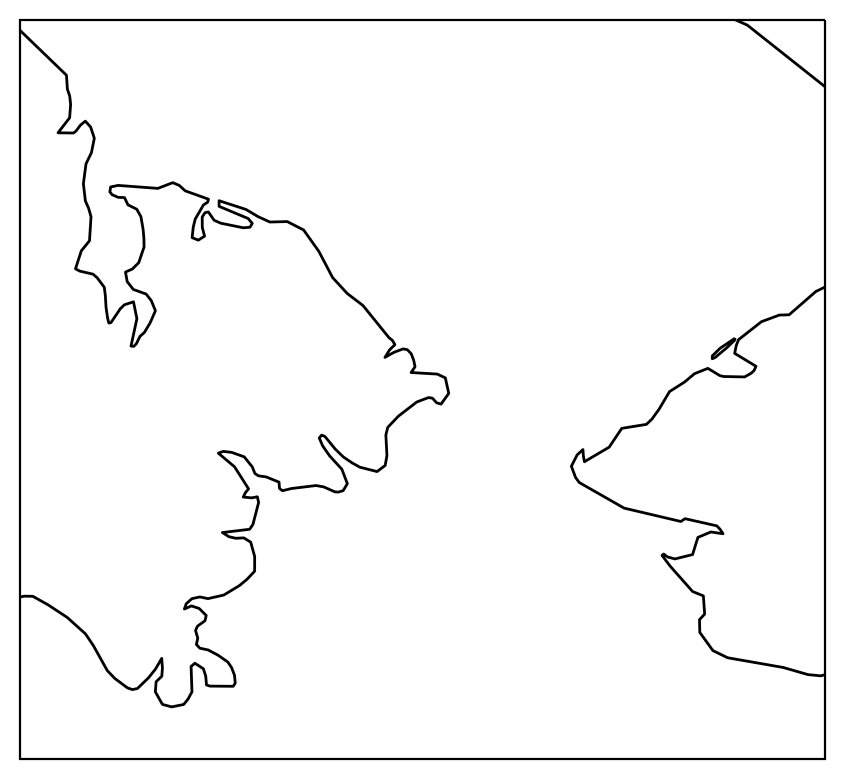

In [70]:
ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))

ax1.set_extent([185, 195, 64, 68], ccrs.PlateCarree()) #[160, 210, 50, 80], ccrs.PlateCarree())

ax1.coastlines(resolution='50m',color='black', linewidth=1, zorder=3)
#ax1.add_feature(cartopy.feature.LAND, facecolor='lightgrey', zorder=2)


ax1.scatter(dsnow_gt_bs_lat_i.lat.sel(y=yind).lon, dsnow_gt_bs_lat_i.lat.sel(y=yind).lat, transform=ccrs.PlateCarree())

#if len(dsnow_bs_trans_j.lon)>1 : 
#    ax1.scatter(dsnow_bs_trans_j.lon, dsnow_bs_trans_j.lat, transform=ccrs.PlateCarree()) #scatter
#else : 
#    ax1.scatter(dsnow_bs_trans_j.lon, np.ones(len(dsnow_bs_trans_j.lon))*dsnow_bs_trans_j.lat.values, transform=ccrs.PlateCarree()) #scatter

gl = ax1.gridlines(draw_labels=False, zorder=4)
ax1.scatter(bs_lons[0], lat_bs_i, transform=ccrs.PlateCarree())
ax1.scatter(bs_lons[1], lat_bs_i, transform=ccrs.PlateCarree())

#ax1.pcolormesh()

#dsnow_bs.so.plot()

In [63]:
dsnow_bs_trans_j_loaded = dsnow_bs_trans_j.load() #dsnow_bs_trans_j.so.mean('time') #.plot()
dsnow_bs_trans_j_loaded

RuntimeError: NetCDF: Authorization failure